## notebook testing blob radius extraction ideas

Need a metric to quantify its success

In [33]:
import sys,os,os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

from invisible_cities.core.core_functions   import shift_to_bin_centers
from invisible_cities.io.dst_io             import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io            import hits_from_df
from invisible_cities.reco                  import paolina_functions as plf
from invisible_cities.types.ic_types        import         types_dict_tracks
from invisible_cities.types.symbols         import                 HitEnergy
from invisible_cities.evm.event_model       import             HitCollection
from invisible_cities.core                  import system_of_units as units

from typing import Tuple, Callable

import core.plotting_functions as plt_func
import core.loading_functions as load_func
import quantification.quantify_functions as quant_func

# preset parameters

In [2]:
# Do you only want one track?
one_track = True

# What data do you want to look at?
#path = '../data/MC/'
path = '../data/CLEAN/'

## lets create the blob info creator extractor from scratch

In [3]:
# output the accuracy of the blob positions
def output_inaccuracy(df, df_MC):

    RECO_b1_xyz = np.column_stack([df.blob1_x[0], df.blob1_y[0], df.blob1_z[0]])
    RECO_b2_xyz = np.column_stack([df.blob2_x[0], df.blob2_y[0], df.blob2_z[0]])

    MC_b1_xyz = np.column_stack([df_MC.blob1_x[0], df_MC.blob1_y[0], df_MC.blob1_z[0]])
    MC_b2_xyz = np.column_stack([df_MC.blob2_x[0], df_MC.blob2_y[0], df_MC.blob2_z[0]])


    dist_b1 = np.linalg.norm((RECO_b1_xyz) - (MC_b1_xyz))
    dist_b2 = np.linalg.norm((RECO_b2_xyz) - (MC_b2_xyz))
    print(f"Blob 1 RECO/MC distance: {dist_b1:.2f}mm")
    print(f"Blob 2 RECO/MC distance: {dist_b2:.2f}mm")

    print('=' * 20)
    print('Assuming blobs flipped: ')
    dist_b1_flip = np.linalg.norm((RECO_b2_xyz) - (MC_b1_xyz))
    dist_b2_flip = np.linalg.norm((RECO_b1_xyz) - (MC_b2_xyz))
    print(f"Blob 1 RECO/ Blob 2 MC distance: {dist_b1_flip:.2f}mm")
    print(f"Blob 2 RECO/ Blob 1 MC distance: {dist_b2_flip:.2f}mm")



def track_blob_info_creator_extractor(vox_size         : Tuple[float, float, float],
                                      strict_vox_size  : bool                      ,
                                      energy_threshold : float                     ,
                                      min_voxels       : int                       ,
                                      blob_radius      : float                     ,
                                      max_num_hits     : int
                                     ) -> Callable:
    """
    For a given paolina parameters returns a function that extract tracks / blob information from a HitCollection.

    Parameters
    ----------
    vox_size         : [float, float, float]
        (maximum) size of voxels for track reconstruction
    strict_vox_size  : bool
        if False allows per event adaptive voxel size,
        smaller of equal thatn vox_size
    energy_threshold : float
        if energy of end-point voxel is smaller
        the voxel will be dropped and energy redistributed to the neighbours
    min_voxels       : int
        after min_voxel number of voxels is reached no dropping will happen.
    blob_radius      : float
        radius of blob

    Returns
    ----------
    A function that from a given HitCollection returns a pandas DataFrame with per track information.
    """
    def create_extract_track_blob_info(hitc):
        df = pd.DataFrame(columns=list(types_dict_tracks.keys()))
        if len(hitc.hits) > max_num_hits:
            return df, hitc, True
        #track_hits is a new Hitcollection object that contains hits belonging to tracks, and hits that couldnt be corrected
        track_hitc = HitCollection(hitc.event, hitc.time)
        out_of_map = np.any(np.isnan([h.Ep for h in hitc.hits]))
        if out_of_map:
            #add nan hits to track_hits, the track_id will be -1
            track_hitc.hits.extend  ([h for h in hitc.hits if np.isnan   (h.Ep)])
            hits_without_nan       = [h for h in hitc.hits if np.isfinite(h.Ep)]
            #create new Hitcollection object but keep the name hitc
            hitc      = HitCollection(hitc.event, hitc.time)
            hitc.hits = hits_without_nan

        hit_energies = np.array([getattr(h, HitEnergy.Ep.value) for h in hitc.hits])

        if len(hitc.hits) > 0 and (hit_energies>0).any():
            voxels           = plf.voxelize_hits(hitc.hits, vox_size, strict_vox_size, HitEnergy.Ep)
            (    mod_voxels,
             dropped_voxels) = plf.drop_end_point_voxels(voxels, energy_threshold, min_voxels)

            for v in dropped_voxels:
                track_hitc.hits.extend(v.hits)

            tracks = plf.make_track_graphs(mod_voxels)
            tracks = sorted(tracks, key=plf.get_track_energy, reverse=True)

            vox_size_x = voxels[0].size[0]
            vox_size_y = voxels[0].size[1]
            vox_size_z = voxels[0].size[2]
            del(voxels)

            track_hits = []
            for c, t in enumerate(tracks, 0):
                tID = c
                energy = plf.get_track_energy(t)
                numb_of_hits   = len([h for vox in t.nodes() for h in vox.hits])
                numb_of_voxels = len(t.nodes())
                numb_of_tracks = len(tracks   )
                pos   = [h.pos for v in t.nodes() for h in v.hits]
                x, y, z = map(np.array, zip(*pos))
                r = np.sqrt(x**2 + y**2)

                e     = [h.Ep for v in t.nodes() for h in v.hits]
                ave_pos = np.average(pos, weights=e, axis=0)
                ave_r   = np.average(r  , weights=e, axis=0)
                distances = plf.shortest_paths(t)
                extr1, extr2, length = plf.find_extrema_and_length(distances)
                extr1_pos = extr1.XYZ
                extr2_pos = extr2.XYZ

                e_blob1, e_blob2, hits_blob1, hits_blob2, blob_pos1, blob_pos2 = plf.blob_energies_hits_and_centres(t, blob_radius)

                overlap = float(sum(h.Ep for h in set(hits_blob1).intersection(set(hits_blob2))))
                list_of_vars = [hitc.event, tID, energy, length, numb_of_voxels,
                                numb_of_hits, numb_of_tracks,
                                min(x), min(y), min(z), min(r), max(x), max(y), max(z), max(r),
                                *ave_pos, ave_r, *extr1_pos,
                                *extr2_pos, *blob_pos1, *blob_pos2,
                                e_blob1, e_blob2, overlap,
                                vox_size_x, vox_size_y, vox_size_z]

                df.loc[c] = list_of_vars

                for vox in t.nodes():
                    for hit in vox.hits:
                        hit.track_id = tID
                        track_hits.append(hit)

            #change dtype of columns to match type of variables
            df = df.apply(lambda x : x.astype(types_dict_tracks[x.name]))
            track_hitc.hits.extend(track_hits)
        return df, track_hitc, out_of_map

    return create_extract_track_blob_info


## load in data

In [4]:

# find .h5 files in path
files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.h5')]
RECO_hits = load_dst(f'{files[0]}', 'RECO', 'Events')
MC_hits = load_dst(f'{files[0]}', 'MC', 'hits')
part_info = load_dst(f'{files[0]}', 'MC', 'particles')
# particle data too

display(RECO_hits)
display(MC_hits)
display(part_info)


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,12300006,2.460001e+13,0,6.515505,-148.908484,1,-19.125,-155.375,0.0,0.0,40.263651,7.188406,574.714427,-1.0,0.001402,-1,-1.0
1,12300006,2.460001e+13,0,6.515505,-148.908484,1,-19.125,-139.825,0.0,0.0,40.263651,5.217391,417.131443,-1.0,0.001018,-1,-1.0
2,12300006,2.460001e+13,0,6.515505,-148.908484,1,-3.575,-155.375,0.0,0.0,40.263651,15.072464,1205.046364,-1.0,0.002943,-1,-1.0
3,12300006,2.460001e+13,0,6.515505,-148.908484,1,-3.575,-139.825,0.0,0.0,40.263651,9.449275,755.471336,-1.0,0.001847,-1,-1.0
4,12300006,2.460001e+13,0,6.515505,-148.908484,1,10.975,-155.375,0.0,0.0,40.263651,8.811594,704.488618,-1.0,0.001721,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420832,12204085,2.440817e+13,1,200.640000,-7.964710,1,288.875,-16.925,0.0,0.0,1028.999786,6.608695,398.112332,-1.0,0.001020,-1,-1.0
420833,12204085,2.440817e+13,1,200.640000,-7.964710,1,304.425,-16.925,0.0,0.0,1028.999786,5.565217,335.252499,-1.0,0.000870,-1,-1.0
420834,12204085,2.440817e+13,1,200.640000,-7.964710,1,257.775,-16.925,0.0,0.0,1032.469781,5.855072,1413.585331,-1.0,0.003604,-1,-1.0
420835,12204085,2.440817e+13,1,200.640000,-7.964710,1,257.775,-1.375,0.0,0.0,1032.469781,5.623188,1357.601767,-1.0,0.003466,-1,-1.0


,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,12300006,32,0,36.513824,-125.199722,105.147636,2.834566,0.000001,ACTIVE
1,12300006,31,0,36.547150,-125.759644,104.332382,2.629001,0.002518,ACTIVE
2,12300006,31,1,36.605511,-126.437218,103.599846,2.633066,0.002213,ACTIVE
3,12300006,31,2,36.760361,-127.064156,102.854980,2.637081,0.002263,ACTIVE
4,12300006,31,3,37.286903,-127.554703,102.174568,2.641119,0.000403,ACTIVE
...,...,...,...,...,...,...,...,...,...
504869,12204085,69,52,209.448700,-34.775208,997.616333,2.203594,0.002556,ACTIVE
504870,12204085,69,53,209.446777,-34.771420,997.600708,2.203996,0.002089,ACTIVE
504871,12204085,69,54,209.446533,-34.771984,997.601624,2.204033,0.000024,ACTIVE
504872,12204085,69,55,209.445343,-34.767570,997.604004,2.204250,0.002396,ACTIVE


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,12300006,1,Tl208,True,0,398.747284,401.567871,563.659546,0.000000,398.747284,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,none,RadioactiveDecay
1,12300006,4,e-,False,1,398.747284,401.567871,563.659546,0.000762,398.747589,...,-0.017302,-0.296512,-0.155331,-0.000000,0.000000,0.000000,0.100120,2.790027e-02,RadioactiveDecay,NoProcess
2,12300006,3,anti_nu_e,False,1,398.747284,401.567871,563.659546,0.000762,-9720.689453,...,-0.919971,-0.797942,-1.187634,-0.919971,-0.797942,-1.187634,1.701039,1.871097e+04,RadioactiveDecay,Transportation
3,12300006,2,Pb208[3197.711],False,1,398.747284,401.567871,563.659546,0.000762,398.747284,...,0.937273,1.094454,1.342965,0.000000,0.000000,0.000000,0.000010,0.000000e+00,RadioactiveDecay,RadioactiveDecay
4,12300006,6,gamma,False,2,398.747284,401.567871,563.659546,0.000762,398.441864,...,-0.275587,-0.117285,0.500404,-0.000000,-0.000000,0.000000,0.583188,6.463141e-01,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49929,12204085,58991,e-,False,58504,246.444626,434.608490,1265.968140,5.705839,246.519730,...,-0.134671,0.556736,0.245645,-0.000000,0.000000,0.000000,0.294949,4.999868e-01,compt,NoProcess
49930,12204085,69,e-,False,66,208.218964,-34.900761,997.138367,2.151887,209.444992,...,-0.233796,-0.094158,-0.059741,-0.000000,0.000000,0.000000,0.061902,6.112734e+00,conv,NoProcess
49931,12204085,68,e-,False,66,384.466278,339.716492,633.618896,0.314111,384.466278,...,0.004220,0.003004,-0.002740,0.000000,0.000000,-0.000000,0.000034,6.015512e-08,compt,NoProcess
49932,12204085,67,e-,False,66,384.466278,339.716492,633.618896,0.314111,384.484070,...,0.379871,-0.092510,0.356779,0.000000,-0.000000,-0.000000,0.224713,1.074977e-01,compt,NoProcess


## select event, and check it

In [23]:
# select event
n = 2

MC_evt   = MC_hits[MC_hits.event_id     == MC_hits.event_id.unique()[n]]
RECO_evt = RECO_hits[RECO_hits.event    == RECO_hits.event.unique()[n]]
prt_evt  = part_info[part_info.event_id == part_info.event_id.unique()[n]]

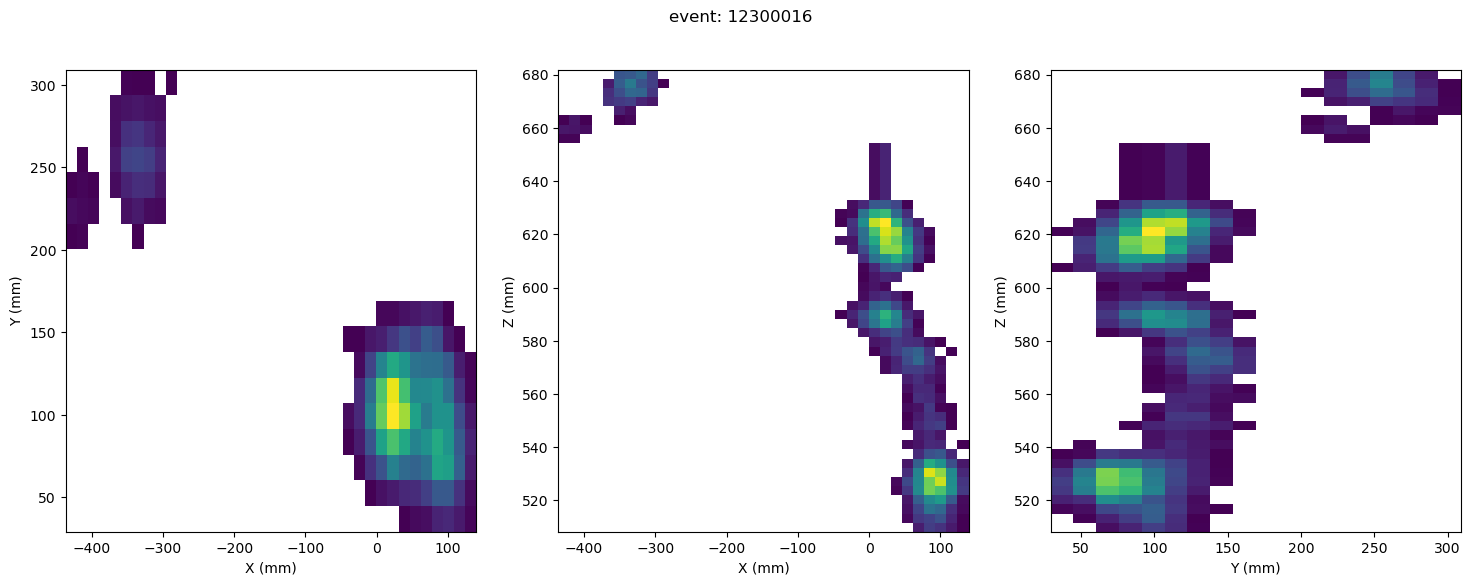

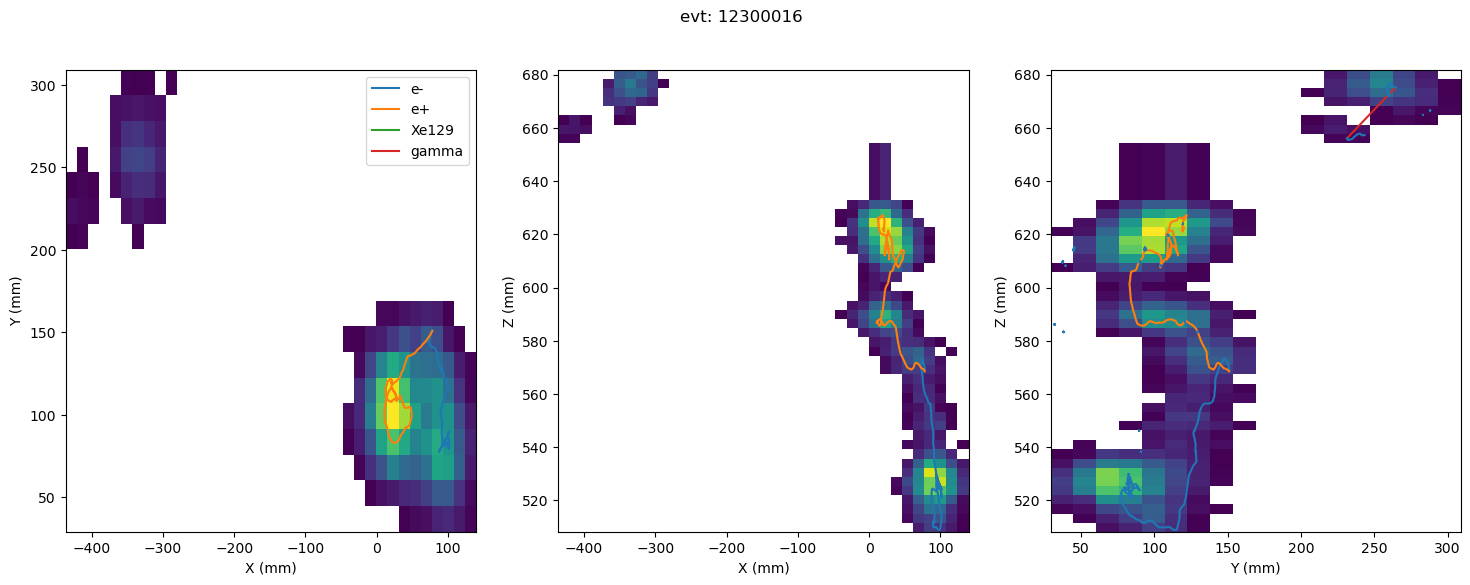

In [24]:
# display event
plt_func.raw_plotter(RECO_evt, RECO_evt.event.unique()[0])
#plt_func.raw_plotter(MC_evt, MC_evt.event_id.unique()[0], MC = True)
plt_func.plot_MC_over_hits(RECO_evt, MC_evt, prt_evt, MC_evt.event_id.unique()[0])

## set up topology extraction

Both:
- MC hits (small voxelisation)
- RECO hits (larger voxelisation)

In [25]:
voxel_size_RECO       = 18 * units.mm
blob_radius_RECO      = 45 * units.mm
scan_radius_RECO      = 60 * units.mm

voxel_size_MC         = 1  * units.mm
blob_radius_MC        = 27 * units.mm
scan_radius_MC        = 40 * units.mm

# topological creation
topological_creator_RECO = track_blob_info_creator_extractor((voxel_size_RECO, voxel_size_RECO, voxel_size_RECO),
                                                        False,
                                                        0 * units.keV,
                                                        0,
                                                        blob_radius_RECO,
                                                        10000000000,
                                                        #scan_radius = scan_radius_RECO
                                                        )

topological_creator_MC = track_blob_info_creator_extractor((voxel_size_MC, voxel_size_MC, voxel_size_MC),
                                                        False,
                                                        0 * units.keV,
                                                        0,
                                                        blob_radius_MC,
                                                        10000000000,
                                                        #scan_radius = scan_radius_MC
                                                        )

In [26]:
display(MC_evt)
MC_untouched_evt = MC_evt.copy(deep = True)
RECO_untouched_evt = RECO_evt.copy(deep = True)

,event_id,particle_id,hit_id,x,y,z,time,energy,label
2261,12300016,35,0,78.486427,151.607864,568.097351,1.566399,0.000014,ACTIVE
2262,12300016,34,0,77.839989,150.960358,568.500366,1.360377,0.000683,ACTIVE
2263,12300016,34,1,77.173630,150.341980,568.910217,1.363930,0.001752,ACTIVE
2264,12300016,34,2,76.531532,149.637634,569.208923,1.367490,0.001342,ACTIVE
2265,12300016,34,3,75.801552,148.990875,569.417358,1.371045,0.002345,ACTIVE
...,...,...,...,...,...,...,...,...,...
3590,12300016,33,272,93.716011,82.539825,529.865601,2.311574,0.000805,ACTIVE
3591,12300016,33,273,93.717514,82.541725,529.864685,2.311656,0.000089,ACTIVE
3592,12300016,33,274,93.719162,82.542175,529.862854,2.311738,0.000615,ACTIVE
3593,12300016,33,275,93.720787,82.542206,529.862427,2.311799,0.000030,ACTIVE


In [27]:
if 'Ec' in RECO_evt.columns:
        RECO_evt['Ep'] = RECO_evt['Ec']
else:
        raise KeyError("RECO_evt does not contain column 'Ec'")

hits_RECO = hits_from_df(RECO_evt)




/tmp/ipykernel_36901/1159503685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RECO_evt['Ep'] = RECO_evt['Ec']


In [28]:

# reshape the MC, this will only work once!
MC_evt.rename(columns={'x': 'X', 'y': 'Y', 'z': 'Z', 'energy': 'E', 'event_id' : 'event'}, inplace=True)
MC_evt['npeak'] = 1
reshaped_hits = MC_evt.rename(columns={'E': 'Ep'}).assign(Q=1)[['event', 'npeak', 'X', 'Y', 'Z', 'Q', 'Ep']]
reshaped_hits['E'] = reshaped_hits.Ep
display(reshaped_hits)

hits_MC   = hits_from_df(reshaped_hits)

/home/e78368jw/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/tmp/ipykernel_36901/2464040654.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MC_evt['npeak'] = 1


,event,npeak,X,Y,Z,Q,Ep,E
2261,12300016,1,78.486427,151.607864,568.097351,1,0.000014,0.000014
2262,12300016,1,77.839989,150.960358,568.500366,1,0.000683,0.000683
2263,12300016,1,77.173630,150.341980,568.910217,1,0.001752,0.001752
2264,12300016,1,76.531532,149.637634,569.208923,1,0.001342,0.001342
2265,12300016,1,75.801552,148.990875,569.417358,1,0.002345,0.002345
...,...,...,...,...,...,...,...,...
3590,12300016,1,93.716011,82.539825,529.865601,1,0.000805,0.000805
3591,12300016,1,93.717514,82.541725,529.864685,1,0.000089,0.000089
3592,12300016,1,93.719162,82.542175,529.862854,1,0.000615,0.000615
3593,12300016,1,93.720787,82.542206,529.862427,1,0.000030,0.000030


In [29]:
# apply topological result.
for evt in hits_RECO.keys():
        df, track_hitc, out_of_map = topological_creator_RECO(hits_RECO[evt])

for evt in hits_MC.keys():
        df_MC, track_hitc_MC, out_of_map_MC = topological_creator_MC(hits_MC[evt])


In [30]:
# one track only?
if one_track:
    df_MC = df_MC.iloc[:1]
    df = df.iloc[:1]



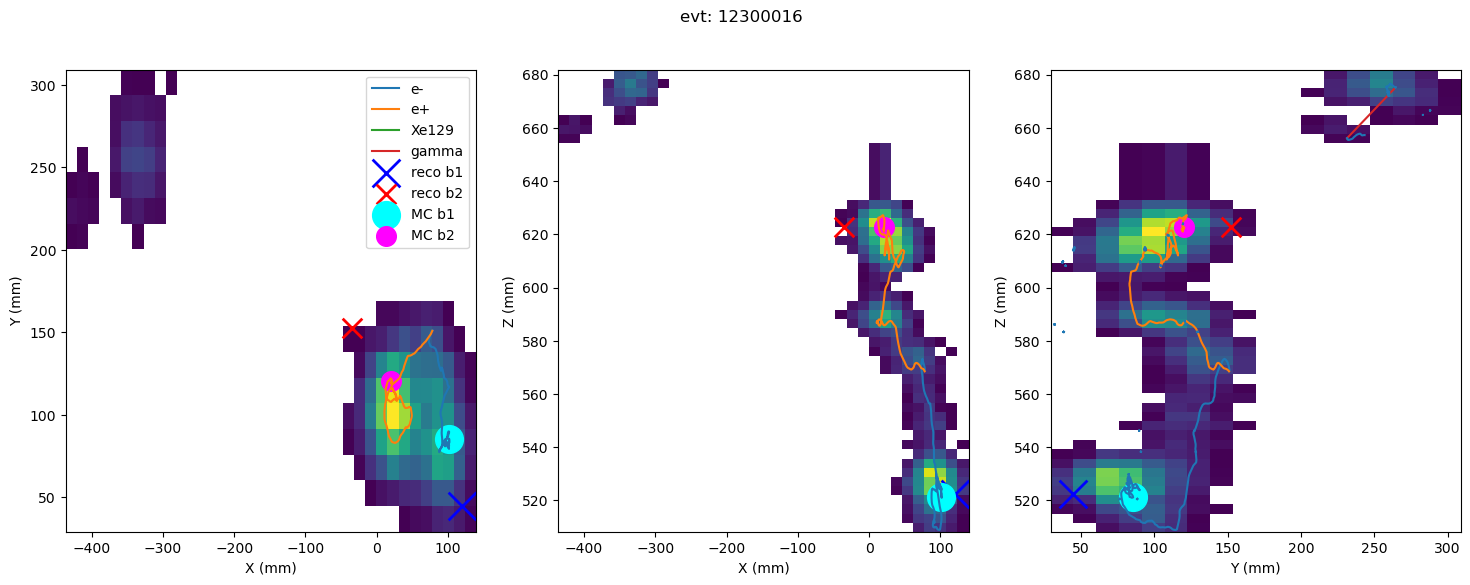

Blob 1 RECO/MC distance: 44.75mm
Blob 2 RECO/MC distance: 63.94mm
Assuming blobs flipped: 
Blob 1 RECO/ Blob 2 MC distance: 182.65mm
Blob 2 RECO/ Blob 1 MC distance: 160.07mm


In [31]:

plt_func.plot_MC_over_hits(RECO_untouched_evt, MC_untouched_evt, prt_evt, MC_untouched_evt.event_id.unique()[0], blob_info = (df, df_MC))
output_inaccuracy(df, df_MC)

# extract all the MC truth information into one DF

In [ ]:
# load it all in


In [ ]:
mc_out = quant_func.extract_true_MC_info()